In [14]:
import networkx as nx
from searchspace import *

In [15]:
distances, idxs = define_space_search_graph(['E2', 'S2', 'H2'], 5)

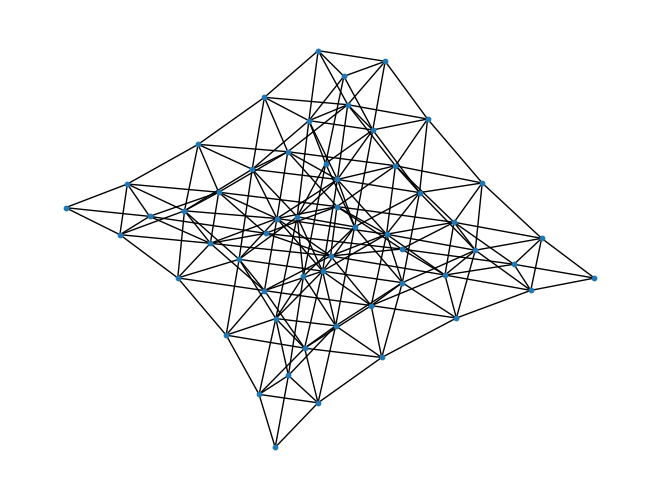

In [16]:
graph = nx.from_numpy_array(distances)
nx.draw(graph, pos=nx.spring_layout(graph), node_size=10)